In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs_recursive_grid import *
from backtest import backtest
from plotting import plot_fills, make_table
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/myconfig_v03.hjson"
        self.exchange = "bitget"
        self.symbols = "SEIUSDT"
        self.market_type = "futures"
        self.user = "bitget_01"
        self.start_date = "2021-01-13"
        self.end_date = "2024-01-29"
        self.starting_balance = 1000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = "y"  # set to "n" to use 1s candles


config = prepare_backtest_config(Args())

config["adg_n_subdivisions"] = 20  # see configs/backtest/default.hjson for details
config["inverse"] = False
sts = time()
if config["ohlcv"]:
    data = await load_hlc_cache(
        config["symbol"],
        config["inverse"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings for SEIUSDT...
first ohlcv at 2023-08-01T02:00:00
fetching https://data.binance.vision/data/futures/um/monthly/klines/SEIUSDT/1m/SEIUSDT-1m-2024-01.zip
Error during HTTP request: 404, message='Not Found', url=URL('https://data.binance.vision/data/futures/um/monthly/klines/SEIUSDT/1m/SEIUSDT-1m-2024-01.zip')
failed to download https://data.binance.vision/data/futures/um/monthly/klines/SEIUSDT/1m/SEIUSDT-1m-2024-01.zip 'NoneType' object is not iterable
fetching https://data.binance.vision/data/futures/um/daily/klines/SEIUSDT/1m/SEIUSDT-1m-2024-01-12.zip
fetching https://data.binance.vision/data/futures/um/daily/klines/SEIUSDT/1m/SEIUSDT-1m-2024-01-22.zip
fetching https://data.binance.vision/data/futures/um/daily/klines/SEIUSDT/1m/SEIUSDT-1m-2024-01-23.zip
fetching https://data.binance.vision/data/futures/um/daily/klines/SEIUSDT/1m/SEIUSDT-1m-2024-01-24.zip
fetching https://data.binance.vision/data/futures/um/daily/klines/SEIUSDT/1m/SEIUSDT-1m-2024-01-25.

In [5]:
config

OrderedDict([('market_type', 'futures'),
             ('user', 'bitget_01'),
             ('symbol', 'SEIUSDT'),
             ('latency_simulation_ms', 300),
             ('starting_balance', 1000.0),
             ('start_date', '2021-01-13'),
             ('end_date', '2024-01-29'),
             ('base_dir', 'backtests'),
             ('ohlcv', True),
             ('adg_n_subdivisions', 20),
             ('enable_interactive_plot', True),
             ('plot_theme', 'dark'),
             ('plot_candles_interval', '1m'),
             ('symbols', ['SEIUSDT']),
             ('spot', False),
             ('exchange', 'bitget'),
             ('session_name', '2021-01-13_2024-01-29'),
             ('caches_dirpath', 'backtests/bitget/SEIUSDT/caches/'),
             ('plots_dirpath', 'backtests/bitget/SEIUSDT/plots/'),
             ('c_mult', 1.0),
             ('hedge_mode', True),
             ('inverse', False),
             ('maker_fee', 0.0002),
             ('min_cost', 5.0),
         

<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

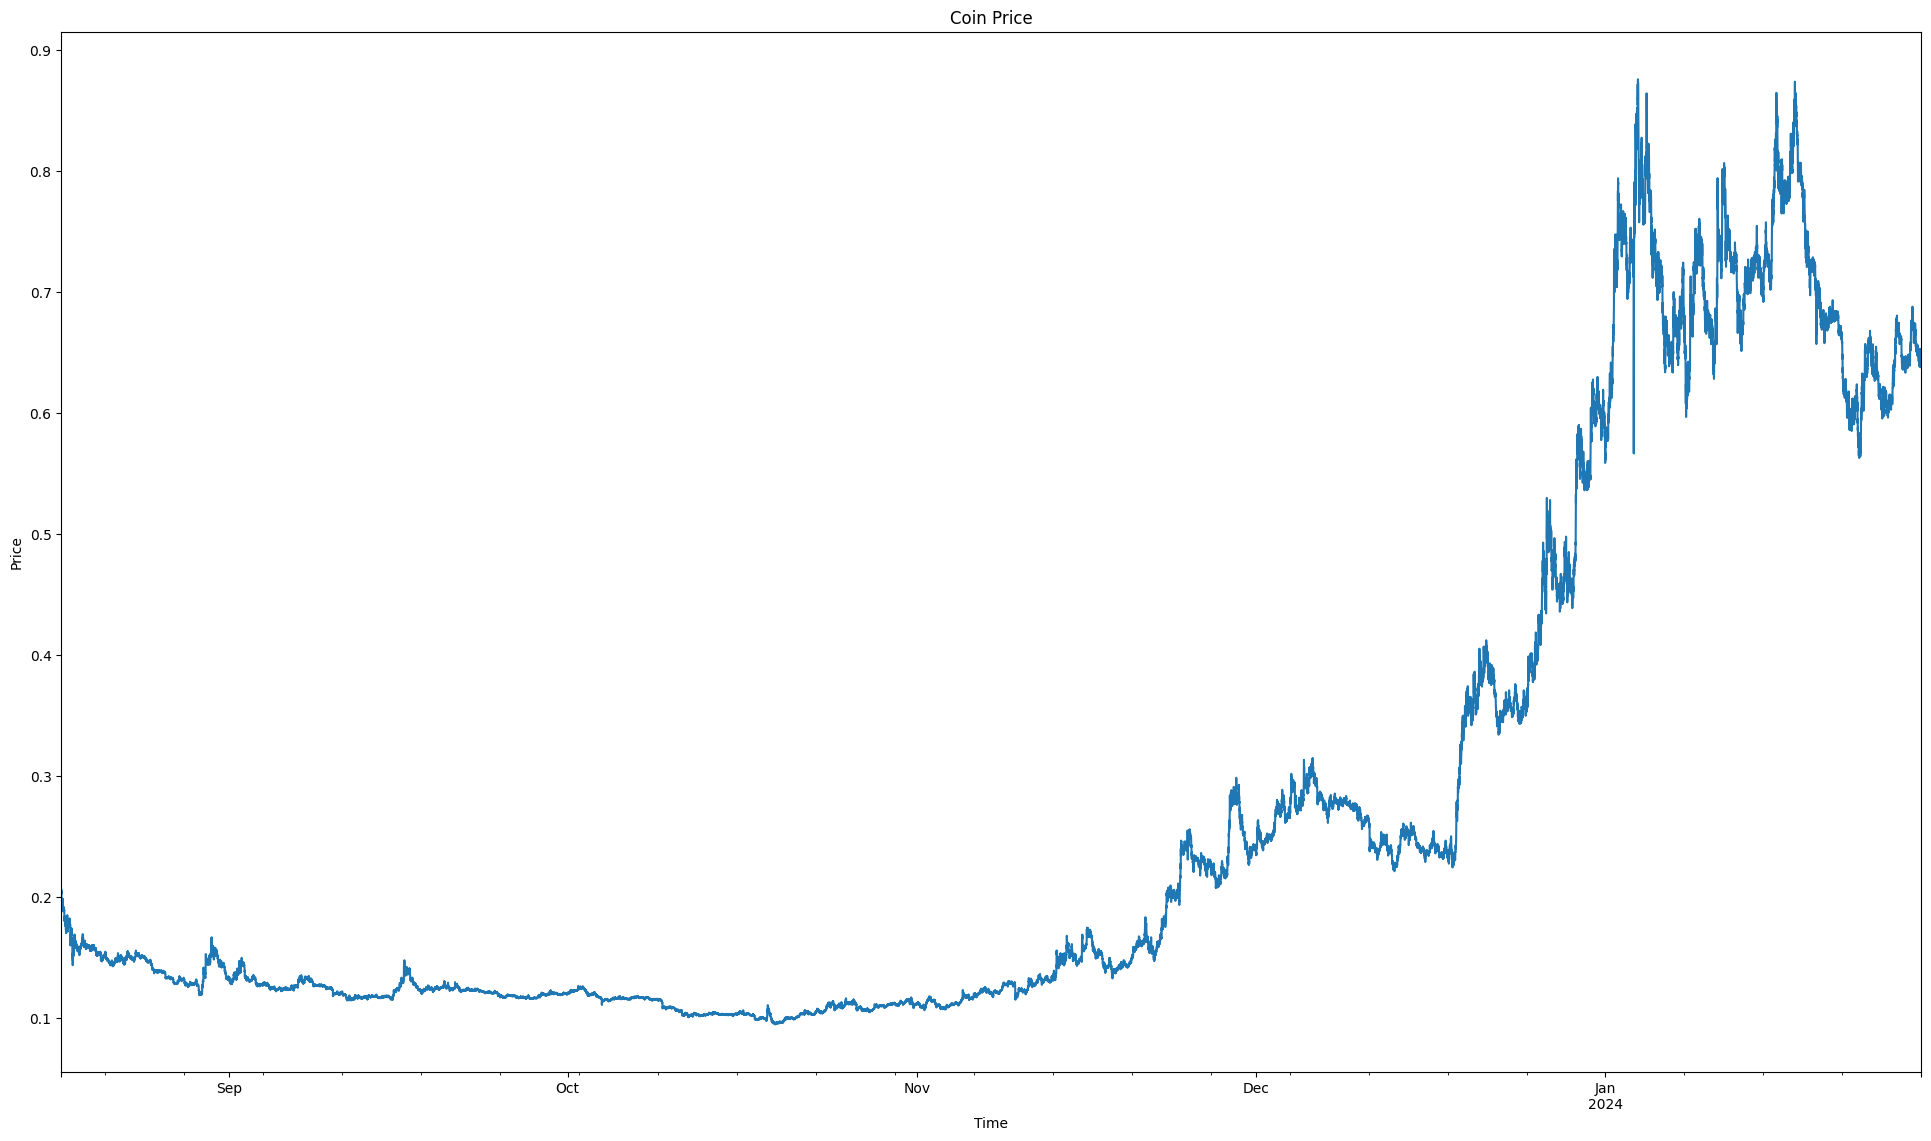

In [6]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df2 = pd.DataFrame({"timestamp": pd.to_datetime(timestamps, unit='ms'), "price": prices}).set_index("timestamp")
df2.price.iloc[::5].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [7]:
# choose a slice on which to test
wsize_days = 3650
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]
len(dataslice)

237450

In [8]:
wallet_exposure = 5.0

tune_default_01 = {
    "config_name": "recursive_grid_0days",
    "logging_level": 0,
    "long": {
        "auto_unstuck_delay_minutes": 120,
        "auto_unstuck_ema_dist": 0,
        "auto_unstuck_qty_pct": 0.01,
        "auto_unstuck_wallet_exposure_threshold": 0.05,
        "backwards_tp": True,
        "ddown_factor": 0.24042182512842744,
        "ema_span_0": 335.99223160614673,
        "ema_span_1": 423.60561144447166,
        "enabled": True,
        "initial_eprice_ema_dist": -0.07946980151596433,
        "initial_qty_pct": 0.012420305169108319,
        "markup_range": 0.005382663097820749,
        "min_markup": 0.003505974125264987,
        "n_close_orders": 10,
        "rentry_pprice_dist": 0.02427005413532235,
        "rentry_pprice_dist_wallet_exposure_weighting": 1.745960920622754,
        "wallet_exposure_limit": wallet_exposure
    },
    "short": {
        "auto_unstuck_delay_minutes": 120,
        "auto_unstuck_ema_dist": 0,
        "auto_unstuck_qty_pct": 0.01,
        "auto_unstuck_wallet_exposure_threshold": 0.05,
        "backwards_tp": True,
        "ddown_factor": 1.954119463453377,
        "ema_span_0": 622.4208572856963,
        "ema_span_1": 1354.1644510245915,
        "enabled": True,
        "initial_eprice_ema_dist": -0.00526472918788522,
        "initial_qty_pct": 0.013658243362644571,
        "markup_range": 0.00695354257700864,
        "min_markup": 0.005332038621022663,
        "n_close_orders": 5,
        "rentry_pprice_dist": 0.036084549507473494,
        "rentry_pprice_dist_wallet_exposure_weighting": 2.296498077184323,
        "wallet_exposure_limit": wallet_exposure
    }
}
from copy import deepcopy

tune_default_02 = deepcopy(tune_default_01)

auto_unstuck_wallet_exposure_threshold = 1.0
auto_unstuck_qty_pct = 0.1
auto_unstuck_ema_dist = -1.0
auto_unstuck_delay_minutes = 20.0

for m in ["long", "short"]:
    tune_default_02[m].update(
        {
            "auto_unstuck_delay_minutes": auto_unstuck_delay_minutes,
            "auto_unstuck_ema_dist": auto_unstuck_ema_dist,
            "auto_unstuck_qty_pct": auto_unstuck_qty_pct,
            "auto_unstuck_wallet_exposure_threshold": auto_unstuck_wallet_exposure_threshold
        }
    )
tune_default_01

{'config_name': 'recursive_grid_0days',
 'logging_level': 0,
 'long': {'auto_unstuck_delay_minutes': 120,
  'auto_unstuck_ema_dist': 0,
  'auto_unstuck_qty_pct': 0.01,
  'auto_unstuck_wallet_exposure_threshold': 0.05,
  'backwards_tp': True,
  'ddown_factor': 0.24042182512842744,
  'ema_span_0': 335.99223160614673,
  'ema_span_1': 423.60561144447166,
  'enabled': True,
  'initial_eprice_ema_dist': -0.07946980151596433,
  'initial_qty_pct': 0.012420305169108319,
  'markup_range': 0.005382663097820749,
  'min_markup': 0.003505974125264987,
  'n_close_orders': 10,
  'rentry_pprice_dist': 0.02427005413532235,
  'rentry_pprice_dist_wallet_exposure_weighting': 1.745960920622754,
  'wallet_exposure_limit': 5.0},
 'short': {'auto_unstuck_delay_minutes': 120,
  'auto_unstuck_ema_dist': 0,
  'auto_unstuck_qty_pct': 0.01,
  'auto_unstuck_wallet_exposure_threshold': 0.05,
  'backwards_tp': True,
  'ddown_factor': 1.954119463453377,
  'ema_span_0': 622.4208572856963,
  'ema_span_1': 1354.1644510245

In [9]:
custom_tuned = {
    "long":
        {
            "auto_unstuck_ema_dist": -0.03873483086285913,
            "auto_unstuck_wallet_exposure_threshold": 0.05913245621339072,
            "backwards_tp": True,
            "ddown_factor": 0.9663971682907846,
            "ema_span_0": 978.9440265702858,
            "ema_span_1": 1173.5898790671702,
            "enabled": True,
            "initial_eprice_ema_dist": 0.004,
            "initial_qty_pct": 0.02446427054013184,
            "markup_range": 0.01,
            "min_markup": 0.008540442504828518,
            "n_close_orders": 4.138115775049637,
            "rentry_pprice_dist": 0.030052654239696483,
            "rentry_pprice_dist_wallet_exposure_weighting": 11.18830873089761,
            "wallet_exposure_limit": wallet_exposure
        },
    "short":
        {
            "auto_unstuck_ema_dist": 0.003,
            "auto_unstuck_wallet_exposure_threshold": 0.03614448454100035,
            "backwards_tp": True,
            "ddown_factor": 0.5909176560534417,
            "ema_span_0": 465.9268827189821,
            "ema_span_1": 623.1580630663296,
            "enabled": True,
            "initial_eprice_ema_dist": -0.0014719870386391079,
            "initial_qty_pct": 0.07142909087153279,
            "markup_range": 0.010541365857953094,
            "min_markup": 0.005403811055924777,
            "n_close_orders": 8.404989017720261,
            "rentry_pprice_dist": 0.024450503837829943,
            "rentry_pprice_dist_wallet_exposure_weighting": 4.358998913087744,
            "wallet_exposure_limit": wallet_exposure
        }
}

In [10]:
hand_tuned_old = {
    "long":
        {
            "auto_unstuck_delay_minutes": 1000.0,
            "auto_unstuck_ema_dist": 0.001,
            "auto_unstuck_qty_pct": 0.04,
            "auto_unstuck_wallet_exposure_threshold": 0.15,
            "backwards_tp": True,
            "ddown_factor": 0.6,
            "ema_span_0": 700,
            "ema_span_1": 1440,
            "enabled": True,
            "initial_eprice_ema_dist": -0.02,
            "initial_qty_pct": 0.01,
            "markup_range": 0.018,
            "min_markup": 0.002,
            "n_close_orders": 16,
            "rentry_pprice_dist": 0.015,
            "rentry_pprice_dist_wallet_exposure_weighting": 15,
            "wallet_exposure_limit": wallet_exposure
        },
    "short":
        {
            "auto_unstuck_delay_minutes": 1000.0,
            "auto_unstuck_ema_dist": 0.001,
            "auto_unstuck_qty_pct": 0.04,
            "auto_unstuck_wallet_exposure_threshold": 0.05,
            "backwards_tp": True,
            "ddown_factor": 0.19,
            "ema_span_0": 1440,
            "ema_span_1": 2880,
            "enabled": True,
            "initial_eprice_ema_dist": 0.02,
            "initial_qty_pct": 0.01,
            "markup_range": 0.018,
            "min_markup": 0.002,
            "n_close_orders": 16,
            "rentry_pprice_dist": 0.015,
            "rentry_pprice_dist_wallet_exposure_weighting": 23,
            "wallet_exposure_limit": wallet_exposure
        }
}

hand_tuned = {
    "long": {
        "enabled": True,
        "ema_span_0": 700,
        "ema_span_1": 1440,
        "initial_qty_pct": 0.01,
        "initial_eprice_ema_dist": -0.02,
        "wallet_exposure_limit": 3.0,
        "ddown_factor": 0.6,
        "rentry_pprice_dist": 0.015,
        "rentry_pprice_dist_wallet_exposure_weighting": 15,
        "min_markup": 0.002,
        "markup_range": 0.018,
        "n_close_orders": 16,
        "auto_unstuck_wallet_exposure_threshold": 0.15,
        "auto_unstuck_ema_dist": 0.001,
        "auto_unstuck_qty_pct": 0.04,
        "auto_unstuck_delay_minutes": 1000.0,
        "backwards_tp": True,
    },
    "short": {
        "enabled": True,
        "ema_span_0": 1440,
        "ema_span_1": 2880,
        "initial_qty_pct": 0.01,
        "initial_eprice_ema_dist": 0.02,
        "wallet_exposure_limit": 3.0,
        "ddown_factor": 0.19,
        "rentry_pprice_dist": 0.015,
        "rentry_pprice_dist_wallet_exposure_weighting": 23,
        "min_markup": 0.002,
        "markup_range": 0.018,
        "n_close_orders": 16,
        "auto_unstuck_wallet_exposure_threshold": 0.05,
        "auto_unstuck_ema_dist": 0.001,
        "auto_unstuck_qty_pct": 0.04,
        "auto_unstuck_delay_minutes": 1000.0,
        "backwards_tp": True,
    },
}

In [11]:
# https://github.com/donewiththedollar/passivbot_optimizations/blob/main/configs/older_versions/v5.9.0/particle_swarm/recursive/November/50maxhrs2022_11_10/TRBUSDT_20221112045924_66dad/config.json
scud_config_v01 = {
    "config_name": "recursive_grid_0days",
    "logging_level": 0,
    "long": {
        "auto_unstuck_ema_dist": 0.0,
        "auto_unstuck_wallet_exposure_threshold": 0.0,
        "backwards_tp": True,
        "ddown_factor": 1.5332919670832106,
        "ema_span_0": 994.4570234365005,
        "ema_span_1": 809.6314365723632,
        "enabled": True,
        "initial_eprice_ema_dist": -0.0729626892502937,
        "initial_qty_pct": 0.004164337313209796,
        "markup_range": 3.860376045868408e-05,
        "min_markup": 0.003975509061571767,
        "n_close_orders": 10,
        "rentry_pprice_dist": 0.044886644419612785,
        "rentry_pprice_dist_wallet_exposure_weighting": 0.6274629923793542,
        "wallet_exposure_limit": wallet_exposure
    },
    "short": {
        "auto_unstuck_ema_dist": 0.06404117534104133,
        "auto_unstuck_wallet_exposure_threshold": 0.059040907831307124,
        "backwards_tp": True,
        "ddown_factor": 1.926940168450328,
        "ema_span_0": 757.8427542032668,
        "ema_span_1": 2542.6568113842004,
        "enabled": True,
        "initial_eprice_ema_dist": -0.03346740325792313,
        "initial_qty_pct": 0.015,
        "markup_range": 0.010626934899588138,
        "min_markup": 0.0027373762710107973,
        "n_close_orders": 14,
        "rentry_pprice_dist": 0.015735267519724233,
        "rentry_pprice_dist_wallet_exposure_weighting": 11.282183289265463,
        "wallet_exposure_limit": wallet_exposure
    }
}

In [12]:
# https://github.com/JohnKearney1/PassivBot-Configurations/blob/main/v5.9.11/recursive_grid_2023-06-20/TRBUSDT.json
scud_config_v02 = {
    "config_name": "recursive_grid_0days",
    "logging_level": 0,
    "long": {
        "auto_unstuck_ema_dist": -0.06602641043077787,
        "auto_unstuck_wallet_exposure_threshold": 0.09174928455661113,
        "backwards_tp": True,
        "ddown_factor": 0.583982625846304,
        "ema_span_0": 774.1252263417617,
        "ema_span_1": 900.6184109130834,
        "enabled": True,
        "initial_eprice_ema_dist": 0.0025,
        "initial_qty_pct": 0.011353375456759535,
        "markup_range": 0.0024563152169057175,
        "min_markup": 0.0033568529748376746,
        "n_close_orders": 14,
        "rentry_pprice_dist": 0.043299552647917634,
        "rentry_pprice_dist_wallet_exposure_weighting": 5.961284719293683,
        "wallet_exposure_limit": wallet_exposure
    },
    "short": {
        "auto_unstuck_ema_dist": -0.02474230220623495,
        "auto_unstuck_wallet_exposure_threshold": 0.04993582161874597,
        "backwards_tp": True,
        "ddown_factor": 0.3343219196693566,
        "ema_span_0": 1320.9205144998998,
        "ema_span_1": 1425.8027226960876,
        "enabled": True,
        "initial_eprice_ema_dist": -0.004800568432362874,
        "initial_qty_pct": 0.01127952039059665,
        "markup_range": 0.0057523538237567945,
        "min_markup": 0.0041853623585175114,
        "n_close_orders": 8,
        "rentry_pprice_dist": 0.03772515667019533,
        "rentry_pprice_dist_wallet_exposure_weighting": 9.726852545217037,
        "wallet_exposure_limit": wallet_exposure
    }
}

In [13]:
all_keys = sorted(
    list(
        set(
            list(custom_tuned["long"].keys()) +
            list(custom_tuned["short"].keys()) +
            list(hand_tuned["long"].keys()) +
            list(hand_tuned["short"].keys()) +
            list(hand_tuned_old["long"].keys()) +
            list(scud_config_v01["long"].keys()) +
            list(tune_default_01["long"].keys()) +
            list(tune_default_01["long"].keys())
        )
    )
)
all_keys

['auto_unstuck_delay_minutes',
 'auto_unstuck_ema_dist',
 'auto_unstuck_qty_pct',
 'auto_unstuck_wallet_exposure_threshold',
 'backwards_tp',
 'ddown_factor',
 'ema_span_0',
 'ema_span_1',
 'enabled',
 'initial_eprice_ema_dist',
 'initial_qty_pct',
 'markup_range',
 'min_markup',
 'n_close_orders',
 'rentry_pprice_dist',
 'rentry_pprice_dist_wallet_exposure_weighting',
 'wallet_exposure_limit']

In [14]:
params_df = pd.concat(
    [
        pd.DataFrame({("custom", k): v for k, v in custom_tuned.items()}, index=all_keys),
        pd.DataFrame({("hand", k): v for k, v in hand_tuned.items()}, index=all_keys),
        pd.DataFrame({("hand_old", k): v for k, v in hand_tuned_old.items()}, index=all_keys),
        pd.DataFrame(
            {("scud_01", k): v for k, v in scud_config_v01.items() if k not in ["config_name", "logging_level"]},
            index=all_keys),
        pd.DataFrame(
            {("scud_02", k): v for k, v in scud_config_v02.items() if k not in ["config_name", "logging_level"]},
            index=all_keys),
        pd.DataFrame(
            {("tune_01", k): v for k, v in tune_default_01.items() if k not in ["config_name", "logging_level"]},
            index=all_keys),
        pd.DataFrame(
            {("tune_02", k): v for k, v in tune_default_02.items() if k not in ["config_name", "logging_level"]},
            index=all_keys),
    ],
    axis=1
)

params_df

custom                  \
                                                         long           short   
auto_unstuck_delay_minutes                                NaN             NaN   
auto_unstuck_ema_dist                           -0.0387348309           0.003   
auto_unstuck_qty_pct                                      NaN             NaN   
auto_unstuck_wallet_exposure_threshold           0.0591324562    0.0361444845   
backwards_tp                                             True            True   
ddown_factor                                     0.9663971683    0.5909176561   
ema_span_0                                     978.9440265703   465.926882719   
ema_span_1                                    1173.5898790672  623.1580630663   
enabled                                                  True            True   
initial_eprice_ema_dist                                 0.004    -0.001471987   
initial_qty_pct                                  0.0244642705    0.0714290909   
markup_range                                             0.01    0.0105413659   
min_markup                                       0.0085404425    0.0054038111   
n_close_orders                                    4.138115775    8.4049890177   
rentry_pprice_dist                               0.0300526542    0.0244505038   
rentry_pprice_dist_wallet_exposure_weighting    11.1883087309    4.3589989131   
wallet_exposure_limit                                     5.0             5.0   

                                                hand         hand_old          \
                                                long   short     long   short   
auto_unstuck_delay_minutes                    1000.0  1000.0   1000.0  1000.0   
auto_unstuck_ema_dist                          0.001   0.001    0.001   0.001   
auto_unstuck_qty_pct                            0.04    0.04     0.04    0.04   
auto_unstuck_wallet_exposure_threshold          0.15    0.05     0.15    0.05   
backwards_tp                                    True    True     True    True   
ddown_factor                                     0.6    0.19      0.6    0.19   
ema_span_0                                       700    1440      700    1440   
ema_span_1                                      1440    2880     1440    2880   
enabled                                         True    True     True    True   
initial_eprice_ema_dist                        -0.02    0.02    -0.02    0.02   
initial_qty_pct                                 0.01    0.01     0.01    0.01   
markup_range                                   0.018   0.018    0.018   0.018   
min_markup                                     0.002   0.002    0.002   0.002   
n_close_orders                                    16      16       16      16   
rentry_pprice_dist                             0.015   0.015    0.015   0.015   
rentry_pprice_dist_wallet_exposure_weighting      15      23       15      23   
wallet_exposure_limit                            3.0     3.0      5.0     5.0   

                                                     scud_01                   \
                                                        long            short   
auto_unstuck_delay_minutes                               NaN              NaN   
auto_unstuck_ema_dist                                    0.0     0.0640411753   
auto_unstuck_qty_pct                                     NaN              NaN   
auto_unstuck_wallet_exposure_threshold                   0.0     0.0590409078   
backwards_tp                                            True             True   
ddown_factor                                    1.5332919671     1.9269401685   
ema_span_0                                    994.4570234365   757.8427542033   
ema_span_1                                    809.6314365724  2542.6568113842   
enabled                                                 True             True   
initial_eprice_ema_dist                        -0.0729626893    -0.0334674033   
ini

In [15]:
custom_tuned_filled = {k: {k1: v.get(k1) for k1 in all_keys} for k, v in custom_tuned.items()}
custom_tuned_filled

{'long': {'auto_unstuck_delay_minutes': None,
  'auto_unstuck_ema_dist': -0.03873483086285913,
  'auto_unstuck_qty_pct': None,
  'auto_unstuck_wallet_exposure_threshold': 0.05913245621339072,
  'backwards_tp': True,
  'ddown_factor': 0.9663971682907846,
  'ema_span_0': 978.9440265702858,
  'ema_span_1': 1173.5898790671702,
  'enabled': True,
  'initial_eprice_ema_dist': 0.004,
  'initial_qty_pct': 0.02446427054013184,
  'markup_range': 0.01,
  'min_markup': 0.008540442504828518,
  'n_close_orders': 4.138115775049637,
  'rentry_pprice_dist': 0.030052654239696483,
  'rentry_pprice_dist_wallet_exposure_weighting': 11.18830873089761,
  'wallet_exposure_limit': 5.0},
 'short': {'auto_unstuck_delay_minutes': None,
  'auto_unstuck_ema_dist': 0.003,
  'auto_unstuck_qty_pct': None,
  'auto_unstuck_wallet_exposure_threshold': 0.03614448454100035,
  'backwards_tp': True,
  'ddown_factor': 0.5909176560534417,
  'ema_span_0': 465.9268827189821,
  'ema_span_1': 623.1580630663296,
  'enabled': True,


In [16]:
custom_tuned_filled_2 = {
    'long': {
        'auto_unstuck_delay_minutes': 90000,
        'auto_unstuck_ema_dist': -0.03873483086285913,
        'auto_unstuck_qty_pct': 0.99,
        'auto_unstuck_wallet_exposure_threshold': 0.05913245621339072,
        'backwards_tp': True,
        'ddown_factor': 0.9663971682907846,
        'ema_span_0': 978.9440265702858,
        'ema_span_1': 1173.5898790671702,
        'enabled': True,
        'initial_eprice_ema_dist': 0.004,
        'initial_qty_pct': 0.02446427054013184,
        'markup_range': 0.01,
        'min_markup': 0.008540442504828518,
        'n_close_orders': 4.138115775049637,
        'rentry_pprice_dist': 0.030052654239696483,
        'rentry_pprice_dist_wallet_exposure_weighting': 11.18830873089761,
        'wallet_exposure_limit': 3},
    'short': {
        'auto_unstuck_delay_minutes': 90000,
        'auto_unstuck_ema_dist': 0.003,
        'auto_unstuck_qty_pct': 0.99,
        'auto_unstuck_wallet_exposure_threshold': 0.03614448454100035,
        'backwards_tp': True,
        'ddown_factor': 0.5909176560534417,
        'ema_span_0': 465.9268827189821,
        'ema_span_1': 623.1580630663296,
        'enabled': True,
        'initial_eprice_ema_dist': -0.0014719870386391079,
        'initial_qty_pct': 0.07142909087153279,
        'markup_range': 0.010541365857953094,
        'min_markup': 0.005403811055924777,
        'n_close_orders': 8.404989017720261,
        'rentry_pprice_dist': 0.024450503837829943,
        'rentry_pprice_dist_wallet_exposure_weighting': 4.358998913087744,
        'wallet_exposure_limit': 3
    }
}

In [17]:
tune_list = [custom_tuned, hand_tuned, scud_config_v01, scud_config_v02, tune_default_01, tune_default_02]
tune_list_names = ["custom_tuned", "hand_tuned", "scud_config_v01", "scud_config_v02", "tune_default_01",
                   "tune_default_02"]
black_list = ["tune_default_01", "tune_default_02"]
for i, t in enumerate(tune_list):
    if tune_list_names[i] in black_list:
        continue
    for m in ["short", "long"]:
        t[m].update(
            {
                "auto_unstuck_delay_minutes": 1000,
                "auto_unstuck_qty_pct": 0.04,
                "auto_unstuck_ema_dist": 0,
                "auto_unstuck_wallet_exposure_threshold": 0.05,
            }
        )
tune_list[0]

{'long': {'auto_unstuck_ema_dist': 0,
  'auto_unstuck_wallet_exposure_threshold': 0.05,
  'backwards_tp': True,
  'ddown_factor': 0.9663971682907846,
  'ema_span_0': 978.9440265702858,
  'ema_span_1': 1173.5898790671702,
  'enabled': True,
  'initial_eprice_ema_dist': 0.004,
  'initial_qty_pct': 0.02446427054013184,
  'markup_range': 0.01,
  'min_markup': 0.008540442504828518,
  'n_close_orders': 4.138115775049637,
  'rentry_pprice_dist': 0.030052654239696483,
  'rentry_pprice_dist_wallet_exposure_weighting': 11.18830873089761,
  'wallet_exposure_limit': 5.0,
  'auto_unstuck_delay_minutes': 1000,
  'auto_unstuck_qty_pct': 0.04},
 'short': {'auto_unstuck_ema_dist': 0,
  'auto_unstuck_wallet_exposure_threshold': 0.05,
  'backwards_tp': True,
  'ddown_factor': 0.5909176560534417,
  'ema_span_0': 465.9268827189821,
  'ema_span_1': 623.1580630663296,
  'enabled': True,
  'initial_eprice_ema_dist': -0.0014719870386391079,
  'initial_qty_pct': 0.07142909087153279,
  'markup_range': 0.01054136

In [18]:
config_to_test = {**config, **tune_default_01}
# config_to_test = {**config, **custom_tuned_filled_2}
# config_to_test = {**config, **custom_tuned_filled}


Grid Span Long = 17.45%
Grid Span Short = 15.70%


,qty,price,type,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
4,-4079.0,0.75888,short_rentry,-6758.0,0.7398177168,4.99968813,0.0251189690,1.5225830534,0.8877904898
3,-1772.0,0.72164,short_rentry,-2679.0,0.7107938074,1.90421661,0.0150299216,1.9536934950,1.0840674169
2,-600.0,0.69859,short_rentry,-907.0,0.6896036714,0.62547053,0.0128635230,1.9543973941,1.7921395039
1,-203.0,0.68031,short_rentry,-307.0,0.6720408143,0.20631653,0.0121550259,1.9519230769,3.9293698046
0,-104.0,0.65590,short_ientry_normal,-104.0,0.6559000000,0.06821360,0.0000000000,NaN,10.2712846154
0,95.0,0.65590,long_ientry_normal,95.0,0.6559000000,0.06231050,0.0000000000,NaN,0.0000000000
1,97.0,0.63963,long_rentry,192.0,0.6476802604,0.12435461,0.0125858081,1.0210526316,0.0000000000
2,98.0,0.63127,long_rentry,290.0,0.6421347241,0.18621907,0.0172108989,0.5104166667,0.0000000000
3,99.0,0.62553,long_rentry,389.0,0.6379088432,0.24814654,0.0197893677,0.3413793103,0.0000000000
4,100.0,0.62108,long_rentry,489.0,0.6344673620,0.31025454,0.0215549719,0.2570694087,0.0000000000


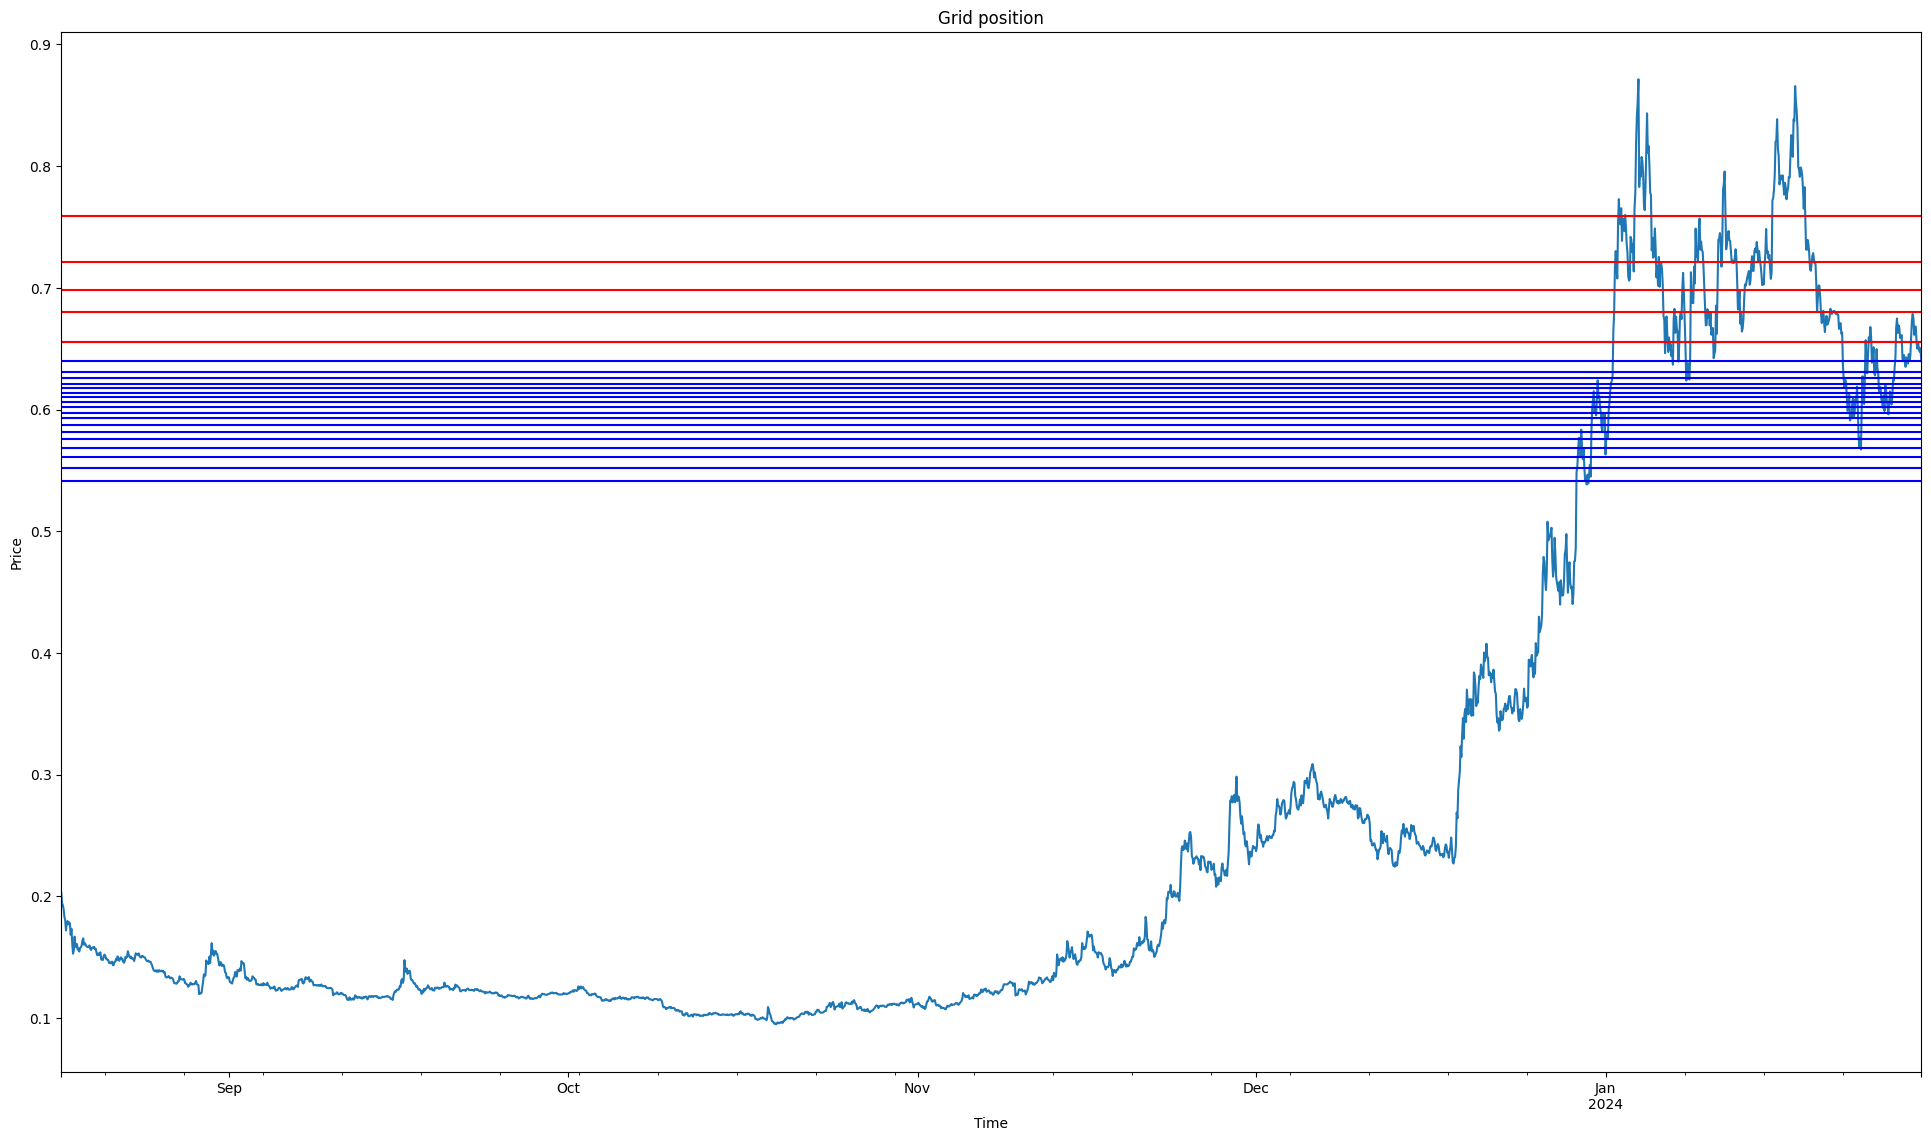

In [19]:
grid_long = calc_recursive_entries_long(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["long"]["initial_qty_pct"],
    config_to_test["long"]["initial_eprice_ema_dist"],
    config_to_test["long"]["ddown_factor"],
    config_to_test["long"]["rentry_pprice_dist"],
    config_to_test["long"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["long"]["wallet_exposure_limit"],
    config_to_test["long"]["auto_unstuck_ema_dist"],
    config_to_test["long"]["auto_unstuck_wallet_exposure_threshold"],
    config_to_test["long"]["auto_unstuck_delay_minutes"]
    or config_to_test["long"]["auto_unstuck_qty_pct"],
    whole_grid=True,
)

grid_short = calc_recursive_entries_short(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["short"]["initial_qty_pct"],
    config_to_test["short"]["initial_eprice_ema_dist"],
    config_to_test["short"]["ddown_factor"],
    config_to_test["short"]["rentry_pprice_dist"],
    config_to_test["short"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["short"]["wallet_exposure_limit"],
    config_to_test["short"]["auto_unstuck_ema_dist"],
    config_to_test["short"]["auto_unstuck_wallet_exposure_threshold"],
    config_to_test["short"]["auto_unstuck_delay_minutes"]
    or config_to_test["short"]["auto_unstuck_qty_pct"],
    whole_grid=True,
)

gdf_long = pd.DataFrame(
    grid_long, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_long.loc[:, "eprice_pprice_diff"] = abs(gdf_long.price - gdf_long.pprice) / gdf_long.price
gdf_long.loc[:, "ddown_factor"] = gdf_long.qty / gdf_long.psize.shift()
gdf_long.loc[:, "bkr_price"] = gdf_long.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)
gdf_short = pd.DataFrame(
    grid_short, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_short.loc[:, "eprice_pprice_diff"] = abs(gdf_short.price - gdf_short.pprice) / gdf_short.price
gdf_short.loc[:, "ddown_factor"] = gdf_short.qty / gdf_short.psize.shift()
gdf_short.loc[:, "bkr_price"] = gdf_short.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
n_ticks = 60 * 60 * 24 * 14  # 14 days
dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"),
        "price": prices[-n_ticks:],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=180): lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
if config_to_test["long"]["enabled"]:
    for i, e in enumerate(gdf_long.itertuples()):
        fig.axhline(y=e.price, color="b", linestyle="-")
    print(f"\nGrid Span Long = {-(gdf_long.price.iloc[-1] / gdf_long.price.iloc[0] - 1) * 100:.2f}%")

if config_to_test["short"]["enabled"]:
    for i, e in enumerate(gdf_short.itertuples()):
        fig.axhline(y=e.price, color="r", linestyle="-")
    print(f"Grid Span Short = {(gdf_short.price.iloc[-1] / gdf_short.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long, gdf_short]).sort_values("price", ascending=False)

In [20]:
# tune_default_01
tune_default_01

{'config_name': 'recursive_grid_0days',
 'logging_level': 0,
 'long': {'auto_unstuck_delay_minutes': 120,
  'auto_unstuck_ema_dist': 0,
  'auto_unstuck_qty_pct': 0.01,
  'auto_unstuck_wallet_exposure_threshold': 0.05,
  'backwards_tp': True,
  'ddown_factor': 0.24042182512842744,
  'ema_span_0': 335.99223160614673,
  'ema_span_1': 423.60561144447166,
  'enabled': True,
  'initial_eprice_ema_dist': -0.07946980151596433,
  'initial_qty_pct': 0.012420305169108319,
  'markup_range': 0.005382663097820749,
  'min_markup': 0.003505974125264987,
  'n_close_orders': 10,
  'rentry_pprice_dist': 0.02427005413532235,
  'rentry_pprice_dist_wallet_exposure_weighting': 1.745960920622754,
  'wallet_exposure_limit': 5.0},
 'short': {'auto_unstuck_delay_minutes': 120,
  'auto_unstuck_ema_dist': 0,
  'auto_unstuck_qty_pct': 0.01,
  'auto_unstuck_wallet_exposure_threshold': 0.05,
  'backwards_tp': True,
  'ddown_factor': 1.954119463453377,
  'ema_span_0': 622.4208572856963,
  'ema_span_1': 1354.1644510245

In [ ]:
verbose = False
counter_i = 0
results = []
# tune_list = [custom_tuned, hand_tuned, scud_config_v01, scud_config_v02, tune_default_01, tune_default_02]
for i, tune_i in enumerate(tune_list):
    # for i, tune_i in enumerate([tune_default_01, tune_default_02]):
    tune_temp = deepcopy(tune_i)
    # auto_unstuck_wallet_exposure_threshold = 1.0
    for auto_unstuck_wallet_exposure_threshold in [0.0, 0.25, 0.50, 0.75, 1.0]:
        # auto_unstuck_qty_pct = 0.1
        for auto_unstuck_qty_pct in [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 1.0]:
            # auto_unstuck_ema_dist = -1.0
            for auto_unstuck_ema_dist in [-0.01, 0.01, -0.05, 0.05, -0.10, 0.10, -0.25, 0.25, -0.50, 0.50, -0.75, 0.75,
                                          -1.0, 1.0]:
                # auto_unstuck_delay_minutes = 20.0
                for auto_unstuck_delay_minutes in [5, 15, 30, 60, 120, 240, 720]:
                    update_dict = {
                        "auto_unstuck_delay_minutes": auto_unstuck_delay_minutes,
                        "auto_unstuck_ema_dist": auto_unstuck_ema_dist,
                        "auto_unstuck_qty_pct": auto_unstuck_qty_pct,
                        "auto_unstuck_wallet_exposure_threshold": auto_unstuck_wallet_exposure_threshold,
                        "wallet_exposure_limit": wallet_exposure
                    }

                    for m in ["long", "short"]:
                        tune_temp[m].update(update_dict)

                    config_to_test_i = deepcopy({**config, **tune_temp})

                    sts = time()
                    fills_long, fills_short, stats = backtest(config_to_test_i, dataslice)
                    elapsed = time() - sts

                    longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test_i)
                    table = make_table({**config_to_test_i, **analysis})
                    if verbose:
                        print(f"\nTune {i}: {tune_list_names[i]}\n\n{update_dict}\n\n")
                        print(f"seconds elapsed {elapsed:.4f}")
                        print(table)
                        print(f"\nTEST: {counter_i}\n")

                    dict_temp = deepcopy(
                        {
                            **{"row": counter_i},
                            **analysis,
                            **update_dict,
                            # **tune_temp
                        }
                    )
                    results.append(dict_temp)
                    counter_i += 1
                    if counter_i % 5000 == 0:
                        results_df = pd.DataFrame(results)
                        results_df.to_csv("/home/raul/Escritorio/results_df.csv")

results_df = pd.DataFrame(results)
results_df.to_csv("/home/raul/Escritorio/results_df.csv")

In [ ]:
analysis

In [ ]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
table = make_table({**config_to_test, **analysis})
print(table)

In [ ]:
sdf["time"] = pd.to_datetime(sdf["timestamp"], unit="ms")
sdf

In [ ]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")
plt.legend()

In [ ]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")
plt.legend()

In [ ]:
df

In [ ]:
longs

In [ ]:
if len(longs) > 0:
    print(len(longs))
    plt.figure()
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")
    plt.legend()

In [ ]:
if len(shorts) > 0:
    print(len(shorts))
    plt.figure()
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")
    plt.legend()

In [ ]:
wes = pd.DataFrame(
    {"WE_short": (sdf.wallet_exposure_short.abs() * -1), "WE_long": sdf.wallet_exposure_long}
)
wes.plot(title="Wallet exposures", xlabel="Time", ylabel="Wallet Exposure")

In [ ]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf[sdf.psize_long != 0].pprice_long.replace(0.0, np.nan).plot()
sdf[sdf.psize_short != 0].pprice_short.replace(0.0, np.nan).plot()
plt.legend()

In [ ]:
lpprices = sdf[sdf.psize_long != 0.0]
spprices = sdf[sdf.psize_short != 0.0]

PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
PADistance_short = ((spprices.pprice_short - spprices.price).abs() / spprices.price) * -1
print(f"Mean price action distance long {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
print(f"Mean price action distance short {PADistance_short.mean():.6f} std {PADistance_short.std():.6f}")

PADistance_long.plot()
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")
plt.legend()

In [ ]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
s = 10
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::s].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::s].plot(
    style="b--",
)
unstucking_band_upper.iloc[::s].plot(style="r--")
long_ientry_band.iloc[::s].plot(style="g-.")

In [ ]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
s = 10
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::s].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::s].plot(style="b--")
unstucking_band_upper.iloc[::s].plot(style="r--")
short_ientry_band.iloc[::s].plot(style="g-.")
plt.legend()